<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/5_updated_Ensembling_Momentum_Factors_different_snapshot_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembling Momentum Factors - Different Snapshot Time (1600 vs 2200)

We have seen a strong cross-sectional momentum effect.

In the last notebook we ensembled our momentum factors into a megafactor.

This time, I want to choose a different snapshot time for making our daily price data to see if we get vastly different results.

We find that some of the factors look better with gap_0 when we snapshot at 2200 vs 1600. Could be just random variation though, unless we have reason to think there's anything special about 2200.

They look pretty much the same if we allow a gap between feature and target.

Maybe something to dig into later.

## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "tibbletime","roll","RcppRoll","Hmisc","Rcpp"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in pacman::p_load(char = libs_to_load, install = FALSE):
“Failed to install/load:
Hmisc”


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpIMY7RD/remotes9d51d2b35a/RWLab-rwRtools-f742350/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.53.tar.gz’

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpIMY7RD/remotes9d6bdf8052/Robot-Wealth-rsims-2589683/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rsims_1.1.0.4.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coincodex data

In [3]:
# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

head(market_cap)

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


Ticker,Date,MarketCapUSD
<chr>,<date>,<dbl>
BTCD,2017-01-01,4.513253e+06
TGC,2017-01-01,1.461090e+04
ATOM,2017-01-02,9.059482e+04
BTC,2017-01-02,1.634320e+10
BTCD,2017-01-02,4.516087e+06
DASH,2017-01-02,8.113380e+07


## Load Binance spot OHLCV

In [4]:
prices <- rwRtools::crypto_get_binance_spot_1h()
head(prices)

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 758.1 Mb )





File successfully transferred


Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


# Creating research universe

In [5]:
#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 16)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=10, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4354.18,72153449099,1,FALSE
2017-08-17,ETH,308.00,28752742413,2,FALSE
2017-08-18,BTC,4250.34,70206129858,1,FALSE
2017-08-18,ETH,299.21,28406320026,2,FALSE
2017-08-19,BTC,4000.00,67500579074,1,FALSE
2017-08-19,ETH,286.14,27839631816,2,FALSE


# Calculate Features

In [6]:
# Rolling days since high
rolling_days_since_high_15 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 15, na_value = NA),
  otherwise = NA
)
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 20, na_value = NA),
  otherwise = NA
)

rolling_days_since_high_25 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 25, na_value = NA),
  otherwise = NA
)
rolling_days_since_high_30 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 30, na_value = NA),
  otherwise = NA
)


features_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Close momo factor
  mutate(
    mom_10 = log(Close / lag(Close, n = 10)),
    mom_15 = log(Close / lag(Close, n = 15)),
    mom_20 = log(Close / lag(Close, n = 20)),
    mom_25 = log(Close / lag(Close, n = 25))
  ) %>%
  # Close to SMA factor
  mutate(
    psma_15 = Close / roll_meanr(Close, 15) - 1,
    psma_20 = Close / roll_meanr(Close, 20) - 1,
    psma_25 = Close / roll_meanr(Close, 25) - 1,
    psma_30 = Close / roll_meanr(Close, 30) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    smaf_2_20 = roll_meanr(Close, 2) / roll_meanr(Close, 20) - 1,
    smaf_3_20 = roll_meanr(Close, 3) / roll_meanr(Close, 20) - 1,
    smaf_3_25 = roll_meanr(Close, 3) / roll_meanr(Close, 25) - 1,
    smaf_5_30 = roll_meanr(Close, 5) / roll_meanr(Close, 30) - 1.
  ) %>%
  # Rolling Close zscore over recent history
  mutate(
    rrp_15 = (Close - roll_meanr(Close, n = 15)) / roll_sdr(Close, n = 15),
    rrp_20 = (Close - roll_meanr(Close, n = 20)) / roll_sdr(Close, n = 20),
    rrp_25 = (Close - roll_meanr(Close, n = 25)) / roll_sdr(Close, n = 25),
    rrp_30 = (Close - roll_meanr(Close, n = 30)) / roll_sdr(Close, n = 20)
  ) %>%
  # Rolling days since recent high
  mutate(
    dsh_15 = -rolling_days_since_high_15(Close),
    dsh_20 = -rolling_days_since_high_20(Close),
    dsh_25 = -rolling_days_since_high_25(Close),
    dsh_30 = -rolling_days_since_high_30(Close),
  ) %>%
  # Calculate returns
  mutate(fwd_log_return_1 = log(lead(Close) / Close),
         fwd_log_return_2 = log(lead(Close,2) / lead(Close, 1)),
         fwd_log_return_3 = log(lead(Close,3) / lead(Close, 2)),
         fwd_log_return_4 = log(lead(Close,4) / lead(Close, 3)),
         fwd_log_return_5 = log(lead(Close,5) / lead(Close, 4)),
         fwd_log_return_6 = log(lead(Close,6) / lead(Close, 5)),
         fwd_log_return_7 = log(lead(Close,7) / lead(Close, 6)),
         fwd_return_1 = lead(Close,1) / Close - 1,
         fwd_return_2 = lead(Close,2) / lead(Close, 1) - 1,
         fwd_return_3 = lead(Close,3) / lead(Close, 2) - 1,
         fwd_return_4 = lead(Close,4) / lead(Close, 3) - 1,
         fwd_return_5 = lead(Close,5) / lead(Close, 4) - 1,
         fwd_return_6 = lead(Close,6) / lead(Close, 5) - 1,
         fwd_return_7 = lead(Close,7) / lead(Close, 6) - 1
  ) %>%
  na.omit() %>%
  ungroup()

In [7]:
head(features_wide)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index,mom_10,mom_15,mom_20,mom_25,⋯,fwd_log_return_5,fwd_log_return_6,fwd_log_return_7,fwd_return_1,fwd_return_2,fwd_return_3,fwd_return_4,fwd_return_5,fwd_return_6,fwd_return_7
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-09-15,BTC,3565.01,55915509214,1,FALSE,-0.1501785,-0.2731948,-0.1795027,-0.1223638,⋯,0.01380667,-0.09033871,-0.03324406,0.02384005,0.013698630,0.072843243,-0.001919628,0.01390242,-0.08637832,-0.03269755
2017-09-15,ETH,239.75,22050359024,2,FALSE,-0.2220836,-0.4780266,-0.3206468,-0.3444250,⋯,0.01374592,-0.09453574,-0.03663861,0.01897810,0.046377405,0.118452451,0.010807597,0.01384083,-0.09020478,-0.03597554
2017-09-16,BTC,3650.00,60495396813,1,FALSE,-0.2355442,-0.2698807,-0.1652822,-0.0677457,⋯,-0.09033871,-0.03324406,0.05487223,0.01369863,0.072843243,-0.001919628,0.013902421,-0.08637832,-0.03269755,0.05640563
2017-09-16,ETH,244.30,23679488724,2,FALSE,-0.3157336,-0.4635358,-0.3152260,-0.2628365,⋯,-0.09453574,-0.03663861,0.08914286,0.04637740,0.118452451,0.010807597,0.013840830,-0.09020478,-0.03597554,0.09323683
2017-09-17,BTC,3700.00,58836899904,1,FALSE,-0.2402993,-0.1820963,-0.1555358,-0.1291370,⋯,-0.03324406,0.05487223,-0.01619338,0.07284324,-0.001919628,0.013902421,-0.086378324,-0.03269755,0.05640563,-0.01606297
2017-09-17,ETH,255.63,23250092978,2,FALSE,-0.2690254,-0.2762628,-0.2945823,-0.2209897,⋯,-0.03663861,0.08914286,0.01361094,0.11845245,0.010807597,0.013840830,-0.090204778,-0.03597554,0.09323683,0.01370399


# Analyzing The 20 day momentum factor

Each day:
 - Rank each coin by its 20 day momentum
 - Group by rank
 - Plot the mean log return n days after for each rank.

`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.


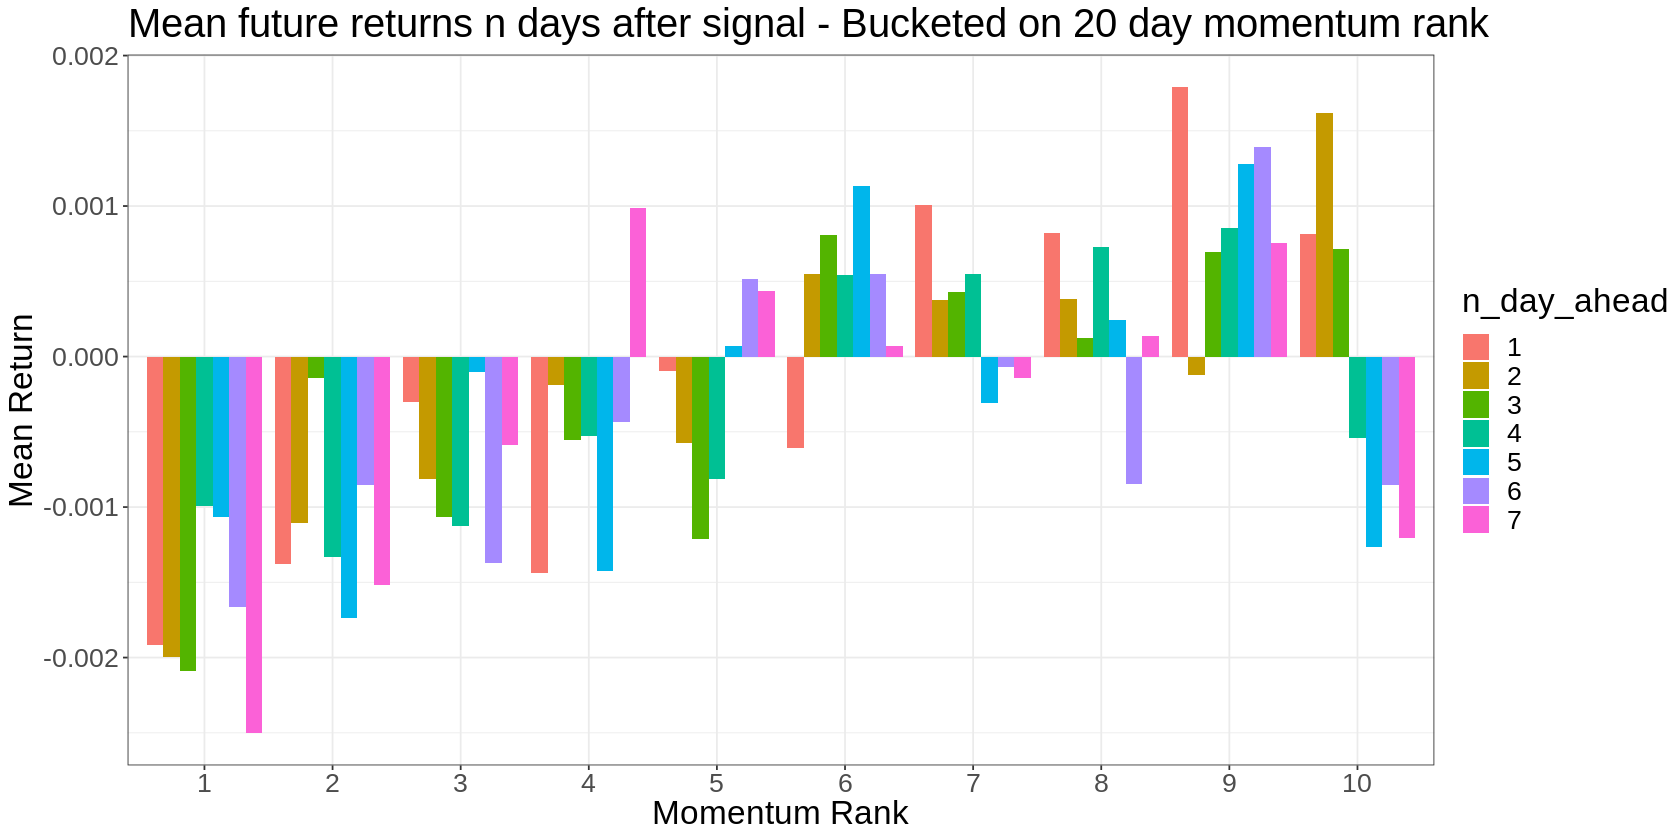

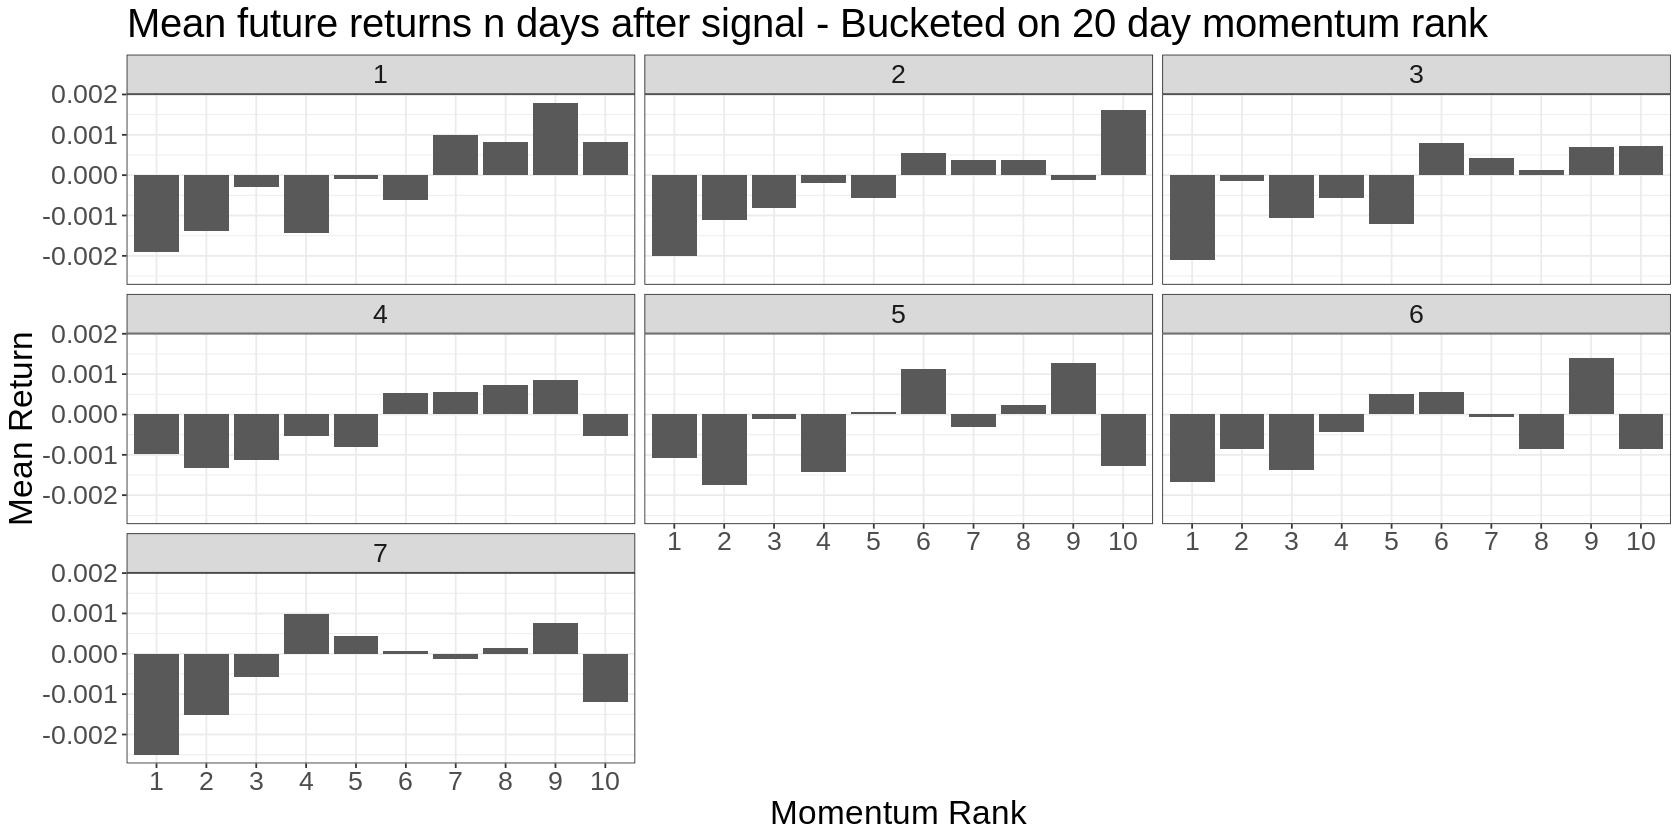

In [8]:
features_wide %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret, fill=n_day_ahead)) + geom_bar(stat='identity', position = 'dodge') +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

features_wide %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret)) + geom_bar(stat='identity', position = 'dodge') + facet_wrap(~n_day_ahead) +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

It looks a lot like in the previous notebook - maybe not quite as good.

Let's plot this separately for each year in our sample.

`summarise()` has grouped output by 'year', 'rank'. You can override using the
`.groups` argument.


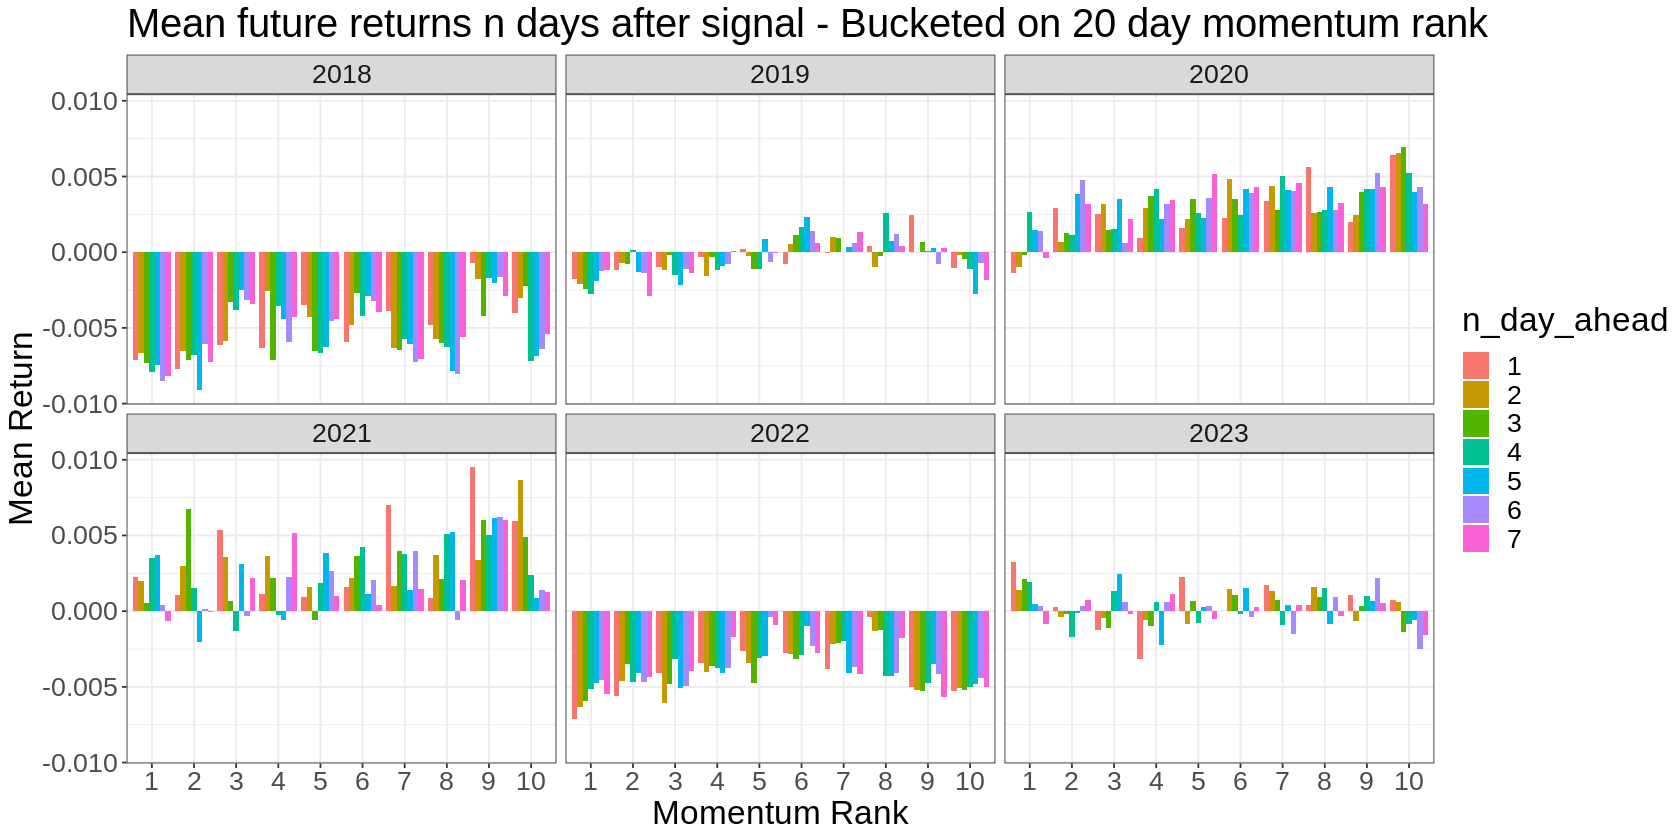

In [9]:
features_wide %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(year, rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret, fill=n_day_ahead)) +
    geom_bar(stat='identity', position = 'dodge') +
    facet_wrap(~year) +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )



# Creating a factor time series

Now, we're going to construct a number of factor time series.

Weight all assets in proportion to their rank.


`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


n_day_ahead,meanreturn,vol,ir
<chr>,<dbl>,<dbl>,<dbl>
1,0.3939617,0.2952849,1.3341750
2,0.2901805,0.2791290,1.0395927
3,0.2299121,0.2776771,0.8279837
4,0.1728585,0.2610404,0.6621906
7,0.1285840,0.2595608,0.4953906
6,0.1239403,0.2623302,0.4724589
5,0.1069345,0.2674041,0.3998987


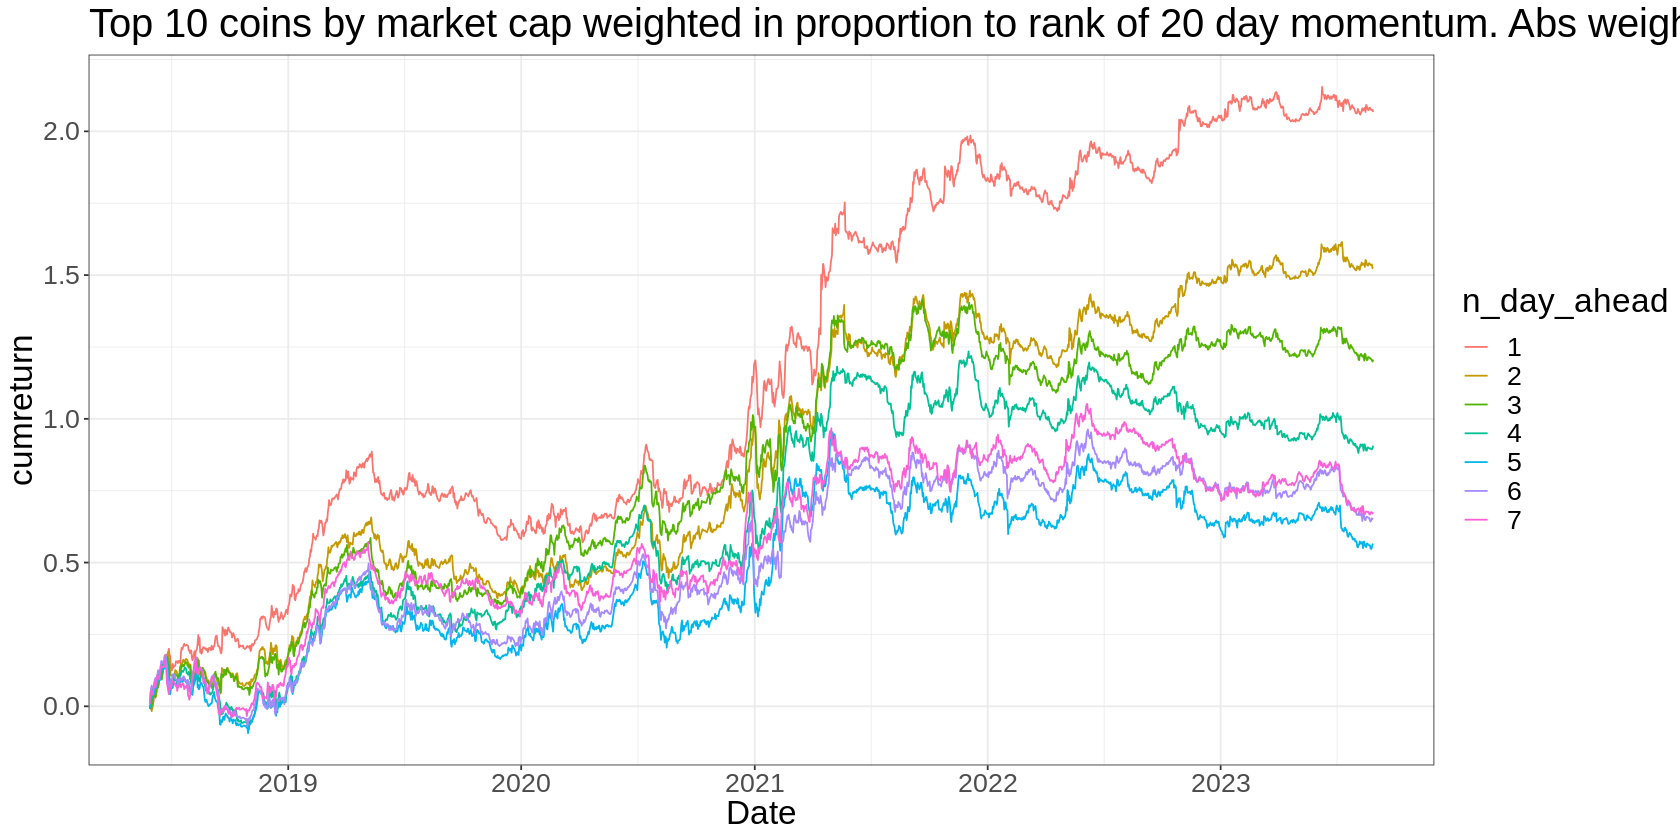

In [10]:
factor_returns <- features_wide %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, n_day_ahead) %>%
  mutate(
    rank = row_number(mom_20),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of 20 day momentum. Abs weights scaled to 1. Cum log returns')

factor_returns %>%
  group_by(n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mom_20,1,0.3939617,0.2952849,1.3341750
mom_15,1,0.3668895,0.2913305,1.2593584
mom_25,2,0.3241180,0.2732351,1.1862241
mom_15,2,0.3071844,0.2785136,1.1029424
mom_20,2,0.2901805,0.2791290,1.0395927
mom_25,1,0.2898516,0.2926331,0.9904950
mom_10,1,0.2648434,0.3064692,0.8641763
mom_25,3,0.2379278,0.2716699,0.8757973
mom_20,3,0.2299121,0.2776771,0.8279837


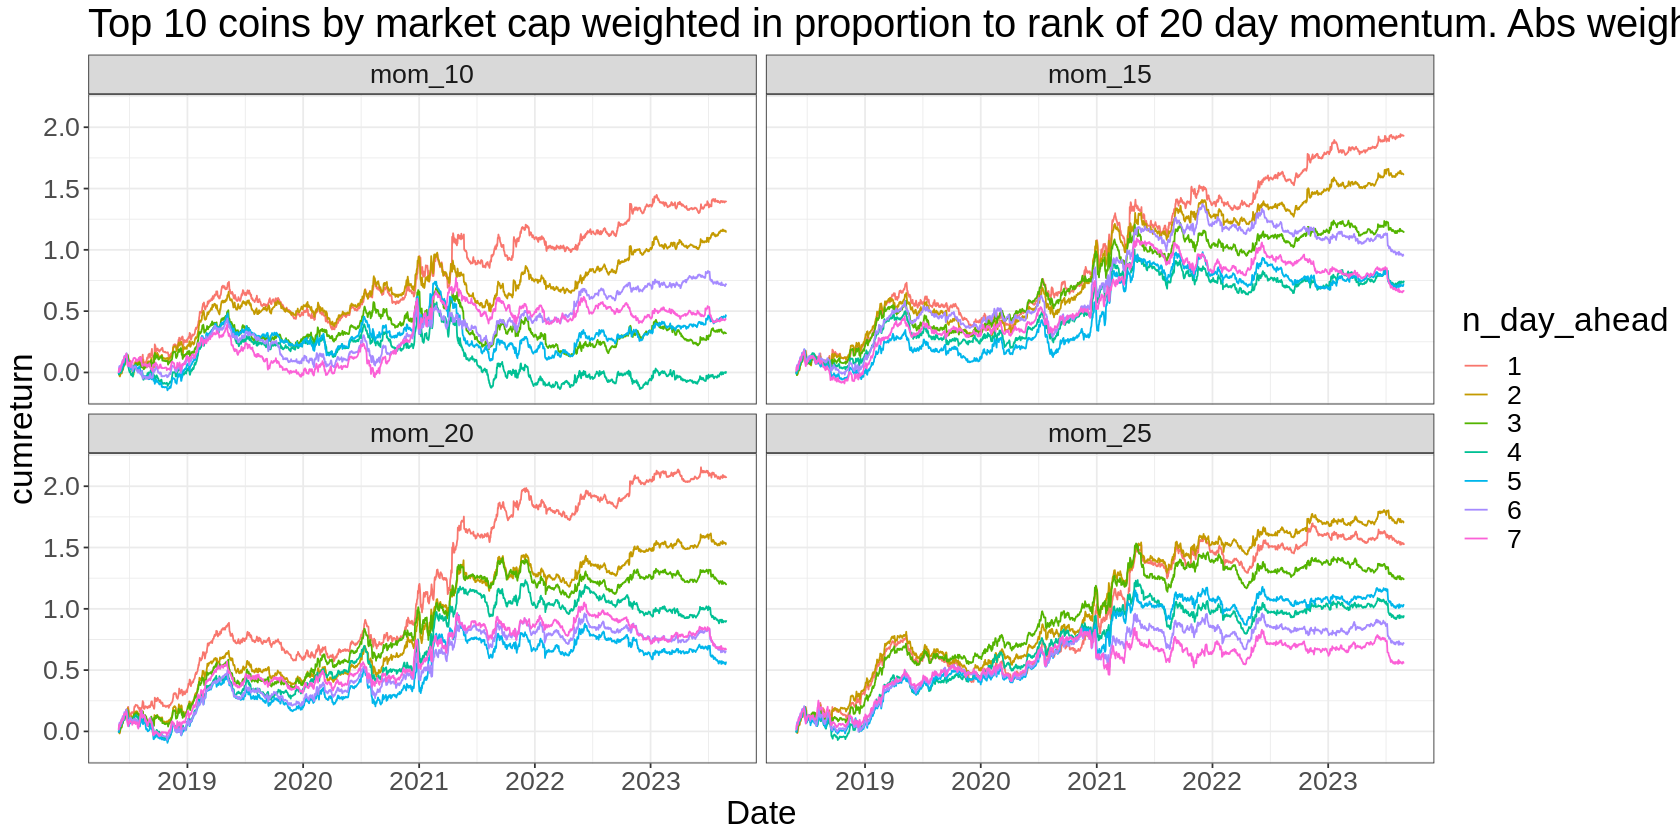

In [11]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('mom_'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of 20 day momentum. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Price to SMA Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
psma_25,1,0.4016721,0.3064147,1.3108773
psma_20,1,0.3951942,0.3066774,1.2886315
psma_15,1,0.3787897,0.3102778,1.2208084
psma_20,2,0.3729254,0.2849111,1.3089181
psma_30,1,0.3682061,0.2976879,1.2368864
psma_30,2,0.3524779,0.2826779,1.2469241
psma_25,2,0.3450242,0.2863549,1.2048829
psma_15,2,0.3058585,0.2849680,1.0733082
psma_25,3,0.2199437,0.2789034,0.7886018


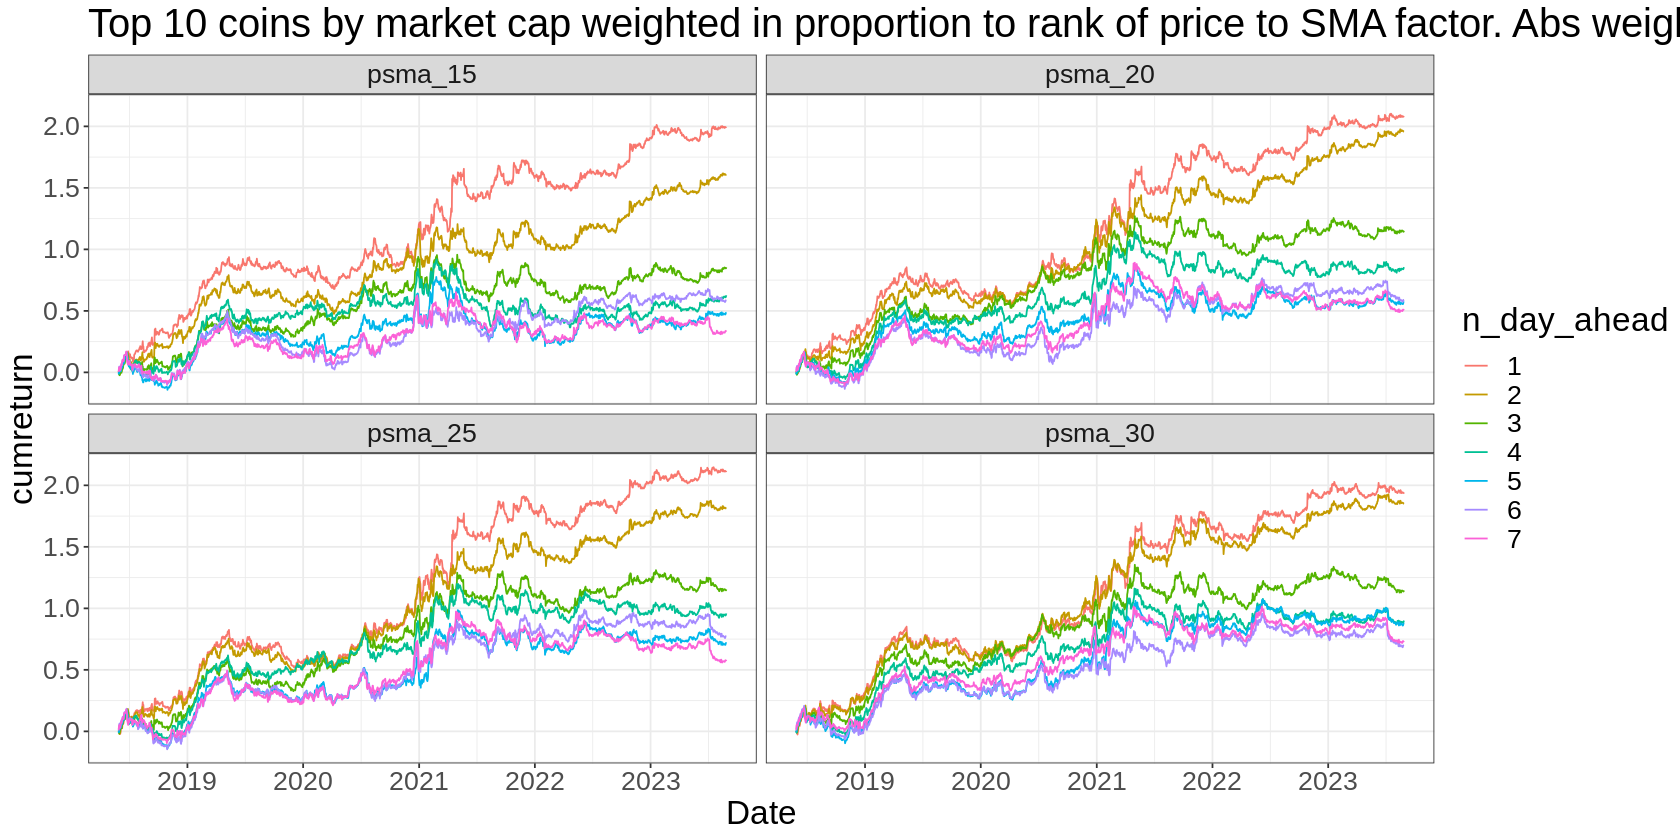

In [12]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('psma'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price to SMA factor. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# SMA Ratio Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
smaf_2_20,1,0.3938299,0.3059301,1.2873200
smaf_3_25,1,0.3581857,0.2995232,1.1958529
smaf_3_20,1,0.3528556,0.2983884,1.1825377
smaf_2_20,2,0.3008958,0.2809734,1.0709050
smaf_5_30,1,0.2879023,0.2926348,0.9838279
smaf_3_20,2,0.2733226,0.2790879,0.9793426
smaf_3_25,2,0.2601251,0.2805467,0.9272080
smaf_5_30,2,0.2417451,0.2765967,0.8739986
smaf_3_25,3,0.2066195,0.2747657,0.7519842


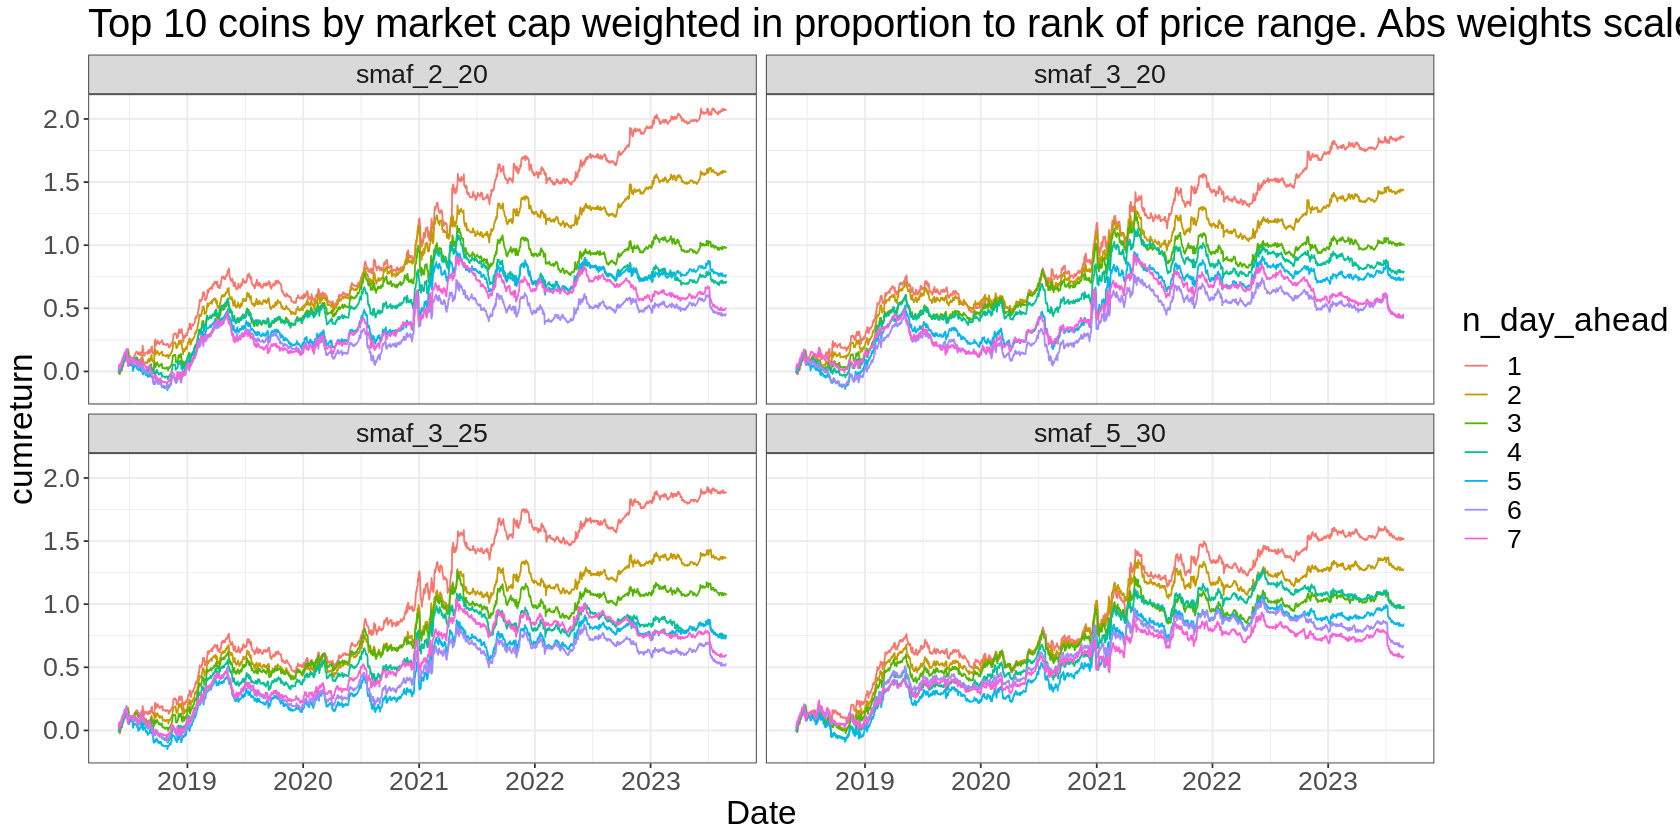

In [13]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('smaf'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price range. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Price Range Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
rrp_15,1,0.6700817,0.2803016,2.390574
rrp_20,1,0.6265574,0.2902200,2.158905
rrp_25,1,0.5644526,0.2896640,1.948646
rrp_30,1,0.5244116,0.2776523,1.888735
rrp_15,2,0.4247010,0.2638101,1.609874
rrp_20,2,0.4075694,0.2659937,1.532252
rrp_25,2,0.3908161,0.2629197,1.486447
rrp_30,2,0.3725429,0.2582842,1.442376
rrp_15,3,0.3220061,0.2615905,1.230955


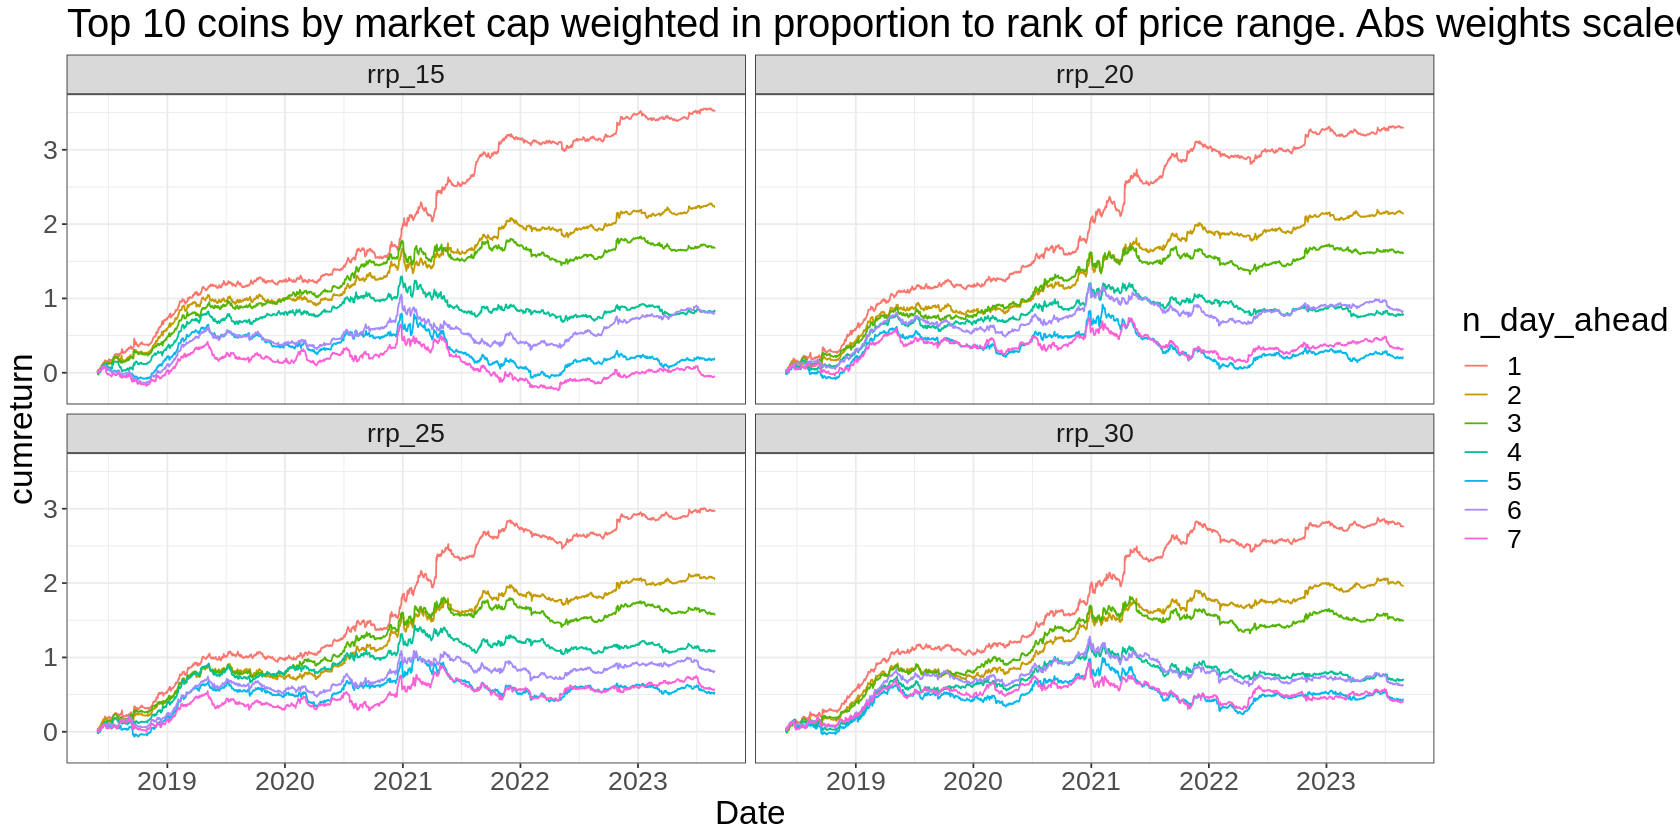

In [14]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('rrp'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price range. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Rolling Days Since High Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
dsh_15,1,0.32631631,0.2472112,1.3199899
dsh_30,1,0.27359366,0.2502602,1.0932368
dsh_25,1,0.25129212,0.2504008,1.0035596
dsh_15,2,0.24582876,0.2436829,1.0088061
dsh_20,1,0.23904524,0.2514005,0.9508542
dsh_15,3,0.22401545,0.2385124,0.9392193
dsh_25,3,0.13441743,0.2341637,0.5740319
dsh_30,3,0.12368467,0.2331623,0.5304661
dsh_30,2,0.09647655,0.2363396,0.4082115


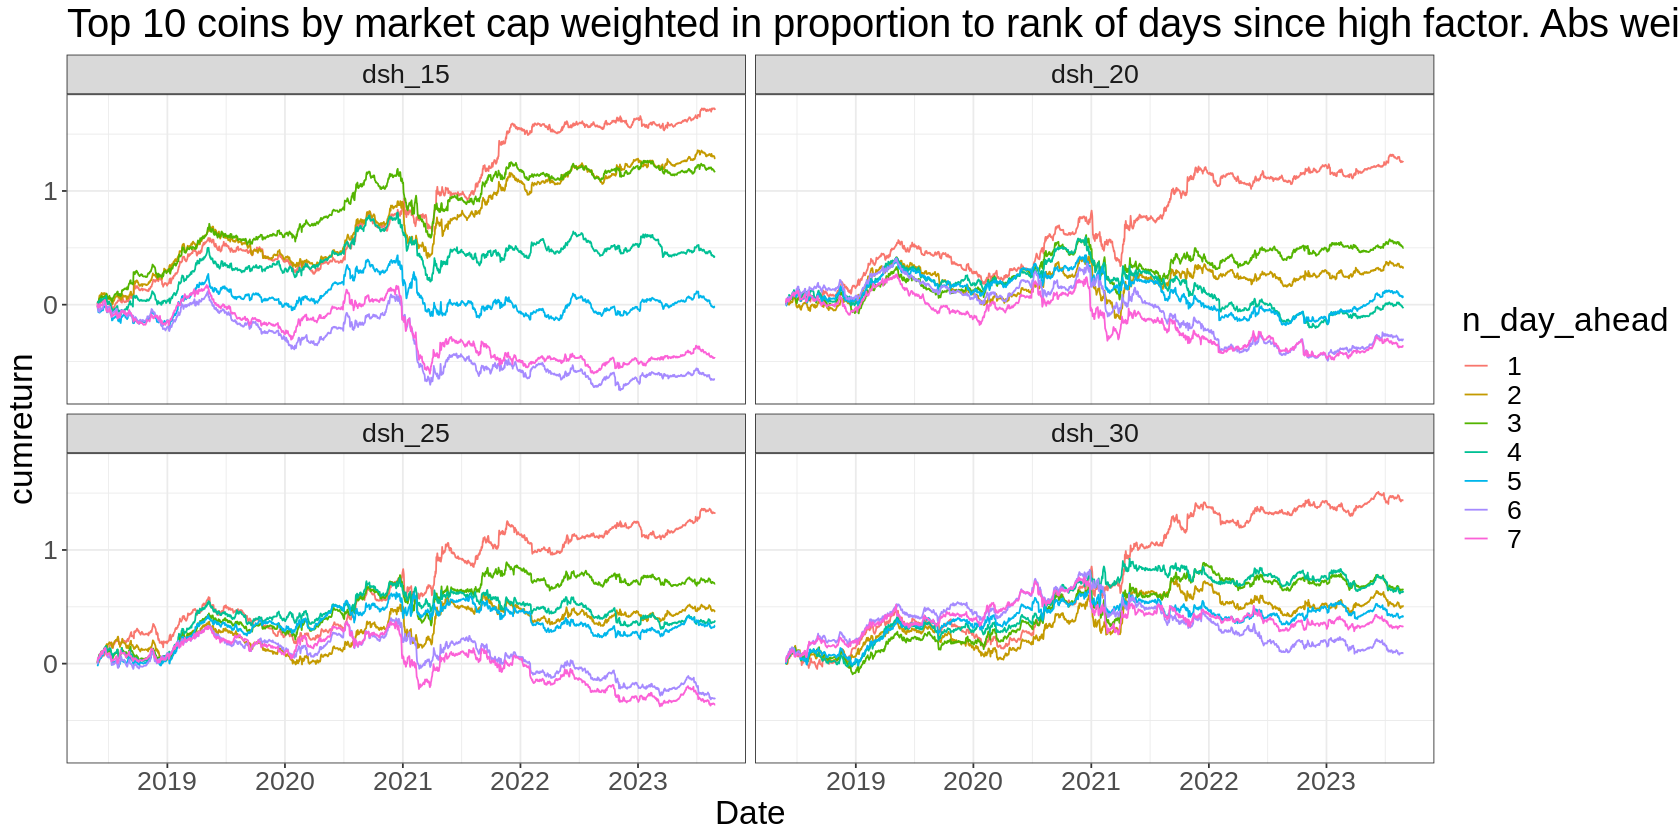

In [15]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('dsh'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of days since high factor. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Mega-Factor


`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


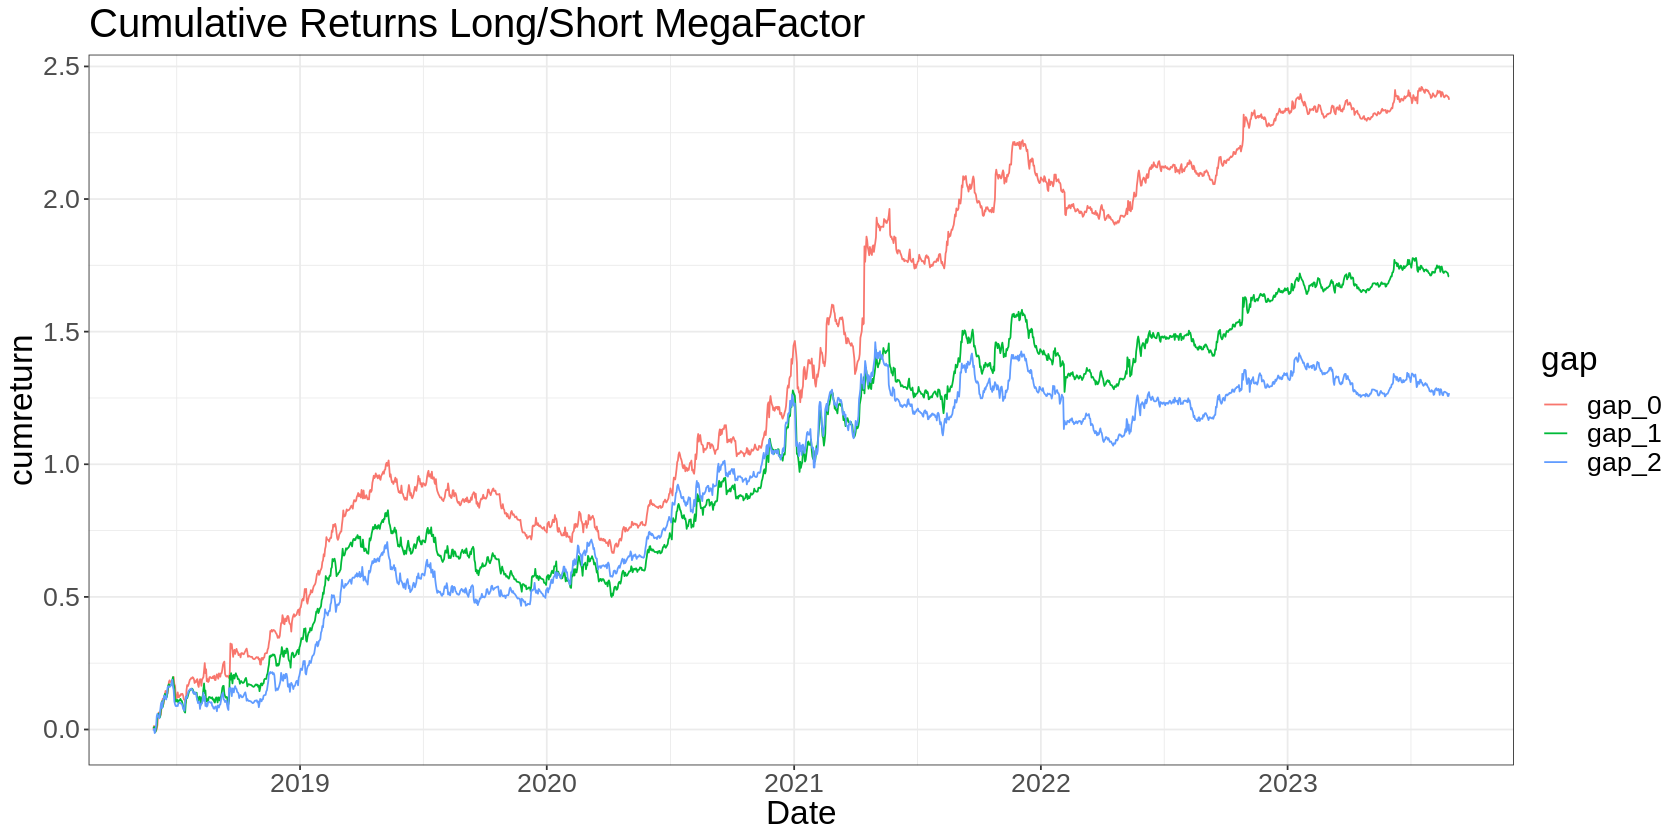

In [16]:
mom_ranks <- features_wide %>%
  pivot_longer(
    c(starts_with('mom_'), starts_with('psma_'), starts_with('smaf_'), starts_with('rrp_'), starts_with('dsh_')),
    names_to = 'feature',
    values_to = 'value'
  ) %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  mutate(
    rank = row_number(value),
    weight = rank - mean(rank),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

megafactor <- mom_ranks %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(rank))

megafactor %>%
  inner_join(features_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  ) %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')


Could argue that some of the factors look better with gap_0 when we snapshot at 2200 vs 1600. Could be just random variation though, unless we have reason to think there's anything special about 2200. Maybe something to dig into later.

# What's Next?
- Tilt exposure based on time series momentum? Let's look at time series momentum factors
- Simulation + trading rules

